In [1]:
import tensorflow as tf
from glob import glob
from os.path import join
from tensorflow.keras import layers, models
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imports.GDL_layers as GDL_layers

In [2]:
# Find a list of all the datafiles
patch_path = "/glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/"
patch_files = sorted(glob(join(patch_path, "*.nc")))
patch_ds = xr.open_dataset(patch_files[0])
csv_path = "/glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/"
csv_files = sorted(glob(join(csv_path, "track_step_*.csv")))
meta_ds = pd.read_csv(csv_files[0])

In [3]:
# Pull selected variables from patch files and join into a single DataSet
num_files = 150
train_split = int(num_files*0.7)
val_split = int(num_files*0.8)
variables = ["REFL_COM_curr", "masks"]
data_list = []
for p, patch_file in enumerate(patch_files[0:train_split]):
    if p % 10 == 0:
        print(f'Train {p}, {patch_file}')
    ds = xr.open_dataset(patch_file)
    data_list.append(ds[variables].compute())
    ds.close()
input_train = xr.concat(data_list, dim="p")["REFL_COM_curr"].expand_dims("channel", axis = -1)
train_masks = xr.concat(data_list, dim="p")["masks"]
data_list = []
for p, patch_file in enumerate(patch_files[train_split:val_split]):
    if p % 10 == 0:
        print(f'Validation {train_split + p}, {patch_file}')
    ds = xr.open_dataset(patch_file)
    data_list.append(ds[variables].compute())
    ds.close()
input_val = xr.concat(data_list, dim="p")["REFL_COM_curr"].expand_dims("channel", axis = -1)
val_masks = xr.concat(data_list, dim="p")["masks"]
data_list = []
for p, patch_file in enumerate(patch_files[val_split:num_files]):
    if p % 10 == 0:
        print(f'Test {val_split + p}, {patch_file}')
    ds = xr.open_dataset(patch_file)
    data_list.append(ds[variables].compute())
    ds.close()
input_test = xr.concat(data_list, dim="p")["REFL_COM_curr"].expand_dims("channel", axis = -1)
test_masks = xr.concat(data_list, dim="p")["masks"]

Train 0, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20101024-0000_d01_model_patches.nc
Train 10, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110201-0000_d01_model_patches.nc
Train 20, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110326-0000_d01_model_patches.nc
Train 30, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110414-0000_d01_model_patches.nc
Train 40, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110425-0000_d01_model_patches.nc
Train 50, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110522-0000_d01_model_patches.nc
Train 60, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110605-0000_d01_model_patches.nc
Train 70, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110615-0000_d01_model_patches.nc
Train 80, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_2

In [4]:
# Pull variables from csv files and join into an array
csv_variables = ["major_axis_length", "minor_axis_length"]
csv_data_list = []
for p, csv_file in enumerate(csv_files[0:train_split]):
    if p % 10 == 0:
        print(f'Train {p}, {csv_file}')
    csv_ds = pd.read_csv(csv_file)
    csv_data_list.append(csv_ds[csv_variables].to_xarray().rename({'index': 'p'}))
output_train = xr.concat(csv_data_list, dim="p").to_array().transpose()
csv_data_list = []
for p, csv_file in enumerate(csv_files[train_split:val_split]):
    if p % 10 == 0:
        print(f'Validation {train_split + p}, {csv_file}')
    csv_ds = pd.read_csv(csv_file)
    csv_data_list.append(csv_ds[csv_variables].to_xarray().rename({'index': 'p'}))
output_val = xr.concat(csv_data_list, dim="p").to_array().transpose()
csv_data_list = []
for p, csv_file in enumerate(csv_files[val_split:num_files]):
    if p % 10 == 0:
        print(f'Test {val_split + p}, {csv_file}')
    csv_ds = pd.read_csv(csv_file)
    csv_data_list.append(csv_ds[csv_variables].to_xarray().rename({'index': 'p'}))
output_test = xr.concat(csv_data_list, dim="p").to_array().transpose()

Train 0, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20101024-0000.csv
Train 10, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110201-0000.csv
Train 20, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110326-0000.csv
Train 30, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110414-0000.csv
Train 40, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110425-0000.csv
Train 50, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110522-0000.csv
Train 60, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110605-0000.csv
Train 70, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110615-0000.csv
Train 80, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTO

In [5]:
print(input_train.shape)
print(input_val.shape)
print(input_test.shape)
print(output_train.shape)
print(output_val.shape)
print(output_test.shape)

(34061, 144, 144, 1)
(4300, 144, 144, 1)
(12985, 144, 144, 1)
(34061, 2)
(4300, 2)
(12985, 2)


In [6]:
# Normalize the training data
scale_stats = pd.DataFrame(index=[0], columns=["mean", "sd"])
scale_stats.loc[0, "mean"] = input_train.mean()
scale_stats.loc[0, "sd"] = input_train.std()
input_train_norm = (input_train - scale_stats.loc[0, "mean"]) / scale_stats.loc[0, "sd"]
input_val_norm = (input_val - scale_stats.loc[0, "mean"]) / scale_stats.loc[0, "sd"]
input_test_norm = (input_test - scale_stats.loc[0, "mean"]) / scale_stats.loc[0, "sd"]

In [7]:
# Normalize output data
output_scale_stats = pd.DataFrame(index=[0], columns=["mean", "sd"])
output_scale_stats.loc[0, "mean"] = output_train.mean()
output_scale_stats.loc[0, "sd"] = output_train.std()
output_train_norm = (output_train - output_scale_stats.loc[0, "mean"]) / output_scale_stats.loc[0, "sd"]
output_val_norm = (output_val - output_scale_stats.loc[0, "mean"]) / output_scale_stats.loc[0, "sd"]
output_test_norm = (output_test - output_scale_stats.loc[0, "mean"]) / output_scale_stats.loc[0, "sd"]

In [8]:
ricnn_backbone = models.Sequential()
ricnn_backbone.add(GDL_layers.RotEquivConv2D(32, (3, 3), rot_axis=False, input_shape=(144, 144, 1)))
ricnn_backbone.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_backbone.add(GDL_layers.RotEquivConv2D(32, (3, 3)))
ricnn_backbone.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_backbone.add(GDL_layers.RotEquivConv2D(64, (3, 3)))
ricnn_backbone.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_backbone.add(GDL_layers.RotEquivConv2D(64, (3, 3)))
ricnn_backbone.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_backbone.add(GDL_layers.RotEquivConv2D(128, (3, 3)))
ricnn_backbone.add(GDL_layers.RotInvPool())
ricnn_backbone.add(layers.Flatten())

2022-07-19 10:38:06.601075: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-19 10:38:11.606624: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30987 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


In [9]:
ricnn_backbone.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rot_equiv_conv2d (RotEquivC  (None, 142, 142, 4, 32)  320       
 onv2D)                                                          
                                                                 
 rot_equiv_pool2d (RotEquivP  (None, 71, 71, 4, 32)    0         
 ool2D)                                                          
                                                                 
 rot_equiv_conv2d_1 (RotEqui  (None, 69, 69, 4, 32)    9248      
 vConv2D)                                                        
                                                                 
 rot_equiv_pool2d_1 (RotEqui  (None, 34, 34, 4, 32)    0         
 vPool2D)                                                        
                                                                 
 rot_equiv_conv2d_2 (RotEqui  (None, 32, 32, 4, 64)    1

In [10]:
cnn_backbone = models.Sequential()
cnn_backbone.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(144, 144, 1)))
cnn_backbone.add(layers.MaxPooling2D((2, 2)))
cnn_backbone.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_backbone.add(layers.MaxPooling2D((2, 2)))
cnn_backbone.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_backbone.add(layers.MaxPooling2D((2, 2)))
cnn_backbone.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_backbone.add(layers.MaxPooling2D((2, 2)))
cnn_backbone.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_backbone.add(layers.Flatten())

In [11]:
cnn_backbone.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 142, 142, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 71, 71, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 34, 34, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 64)      

In [12]:
head = models.Sequential()
head.add(layers.Dense(32, input_shape=(3200,)))
head.add(layers.LeakyReLU(alpha=0.05))
head.add(layers.Dense(2))

In [13]:
head.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                102432    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 102,498
Trainable params: 102,498
Non-trainable params: 0
_________________________________________________________________


In [18]:
cnn_model = models.Sequential()
cnn_model.add(cnn_backbone)
cnn_model.add(head)

In [19]:
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 3200)              138848    
                                                                 
 sequential_2 (Sequential)   (None, 2)                 102498    
                                                                 
Total params: 241,346
Trainable params: 241,346
Non-trainable params: 0
_________________________________________________________________


In [20]:
cnn_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)

In [21]:
cnn_hist = cnn_model.fit(x=input_train_norm, y=output_train_norm, epochs=10, validation_data=(input_val_norm, output_val_norm))

Epoch 1/10


2022-07-19 10:41:13.697790: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1065/1065 [==============================] - 20s 12ms/step - loss: 0.3222 - mse: 0.3222 - val_loss: 0.1529 - val_mse: 0.1529
Epoch 2/10
1065/1065 [==============================] - 14s 13ms/step - loss: 0.1852 - mse: 0.1852 - val_loss: 0.1199 - val_mse: 0.1199
Epoch 3/10
1065/1065 [==============================] - 12s 11ms/step - loss: 0.1364 - mse: 0.1364 - val_loss: 0.0925 - val_mse: 0.0925
Epoch 4/10
1065/1065 [==============================] - 12s 11ms/step - loss: 0.1079 - mse: 0.1079 - val_loss: 0.0799 - val_mse: 0.0799
Epoch 5/10
1065/1065 [==============================] - 12s 11ms/step - loss: 0.0836 - mse: 0.0836 - val_loss: 0.0666 - val_mse: 0.0666
Epoch 6/10
1065/1065 [==============================] - 12s 11ms/step - loss: 0.0688 - mse: 0.0688 - val_loss: 0.0665 - val_mse: 0.0665
Epoch 7/10
1065/1065 [==============================] - 12s 11ms/step - loss: 0.0603 - mse: 0.0603 - val_loss: 0.0683 - val_mse: 0.0683
Epoch 8/10
1065/1065 [==============================] - 12s

In [22]:
cnn_latent_train = cnn_backbone.predict(input_train_norm)

1065/1065 [==============================] - 7s 6ms/step


In [23]:
ricnn_backbone.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)

In [24]:
latent_ricnn_cnn_hist = ricnn_backbone.fit(x=input_train_norm, y=cnn_latent_train, epochs=10)

Epoch 1/10
1065/1065 [==============================] - 69s 61ms/step - loss: 0.0102 - mse: 0.0102
Epoch 2/10
1065/1065 [==============================] - 65s 61ms/step - loss: 0.0077 - mse: 0.0077
Epoch 3/10
1065/1065 [==============================] - 65s 61ms/step - loss: 0.0069 - mse: 0.0069
Epoch 4/10
1065/1065 [==============================] - 65s 61ms/step - loss: 0.0065 - mse: 0.0065
Epoch 5/10
1065/1065 [==============================] - 65s 61ms/step - loss: 0.0062 - mse: 0.0062
Epoch 6/10
1065/1065 [==============================] - 65s 61ms/step - loss: 0.0060 - mse: 0.0060
Epoch 7/10
1065/1065 [==============================] - 65s 61ms/step - loss: 0.0058 - mse: 0.0058
Epoch 8/10
1065/1065 [==============================] - 65s 61ms/step - loss: 0.0057 - mse: 0.0057
Epoch 9/10
1065/1065 [==============================] - 65s 61ms/step - loss: 0.0056 - mse: 0.0056
Epoch 10/10
1065/1065 [==============================] - 65s 61ms/step - loss: 0.0055 - mse: 0.0055


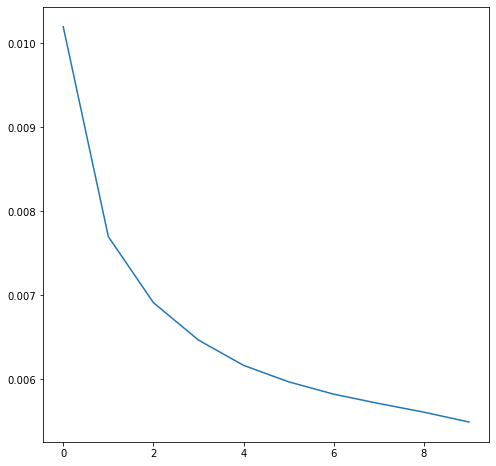

In [25]:
F, ax = plt.subplots(figsize=(8, 8))
ax.plot(latent_ricnn_cnn_hist.history['mse'])

In [34]:
lricnn_model = models.Sequential()
lricnn_model.add(ricnn_backbone)
lricnn_model.add(head)

In [35]:
lricnn_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)

In [36]:
lricnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 3200)              138848    
                                                                 
 sequential_2 (Sequential)   (None, 2)                 102498    
                                                                 
Total params: 241,346
Trainable params: 241,346
Non-trainable params: 0
_________________________________________________________________


In [29]:
ricnn_model = models.Sequential()
ricnn_model.add(GDL_layers.RotEquivConv2D(32, (3, 3), rot_axis=False, kernel_regularizer='L2', input_shape=(144, 144, 1)))
ricnn_model.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_model.add(GDL_layers.RotEquivConv2D(32, (3, 3)))
ricnn_model.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_model.add(GDL_layers.RotEquivConv2D(64, (3, 3)))
ricnn_model.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_model.add(GDL_layers.RotEquivConv2D(64, (3, 3)))
ricnn_model.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_model.add(GDL_layers.RotEquivConv2D(128, (3, 3)))
ricnn_model.add(GDL_layers.RotInvPool())
ricnn_model.add(layers.Flatten())
ricnn_model.add(layers.Dense(32, activation='relu'))
ricnn_model.add(layers.Dense(2))

In [30]:
ricnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rot_equiv_conv2d_5 (RotEqui  (None, 142, 142, 4, 32)  320       
 vConv2D)                                                        
                                                                 
 rot_equiv_pool2d_4 (RotEqui  (None, 71, 71, 4, 32)    0         
 vPool2D)                                                        
                                                                 
 rot_equiv_conv2d_6 (RotEqui  (None, 69, 69, 4, 32)    9248      
 vConv2D)                                                        
                                                                 
 rot_equiv_pool2d_5 (RotEqui  (None, 34, 34, 4, 32)    0         
 vPool2D)                                                        
                                                                 
 rot_equiv_conv2d_7 (RotEqui  (None, 32, 32, 4, 64)   

In [31]:
ricnn_model.compile(
    optimizer='nadam',
    loss='mse',
    metrics=['mse']
)

In [32]:
ricnn_history = ricnn_model.fit(x=input_train_norm, y=output_train_norm, epochs=10, validation_data=(input_val_norm, output_val_norm))

Epoch 1/10
1065/1065 [==============================] - 75s 66ms/step - loss: 0.3721 - mse: 0.3576 - val_loss: 0.1915 - val_mse: 0.1790
Epoch 2/10
1065/1065 [==============================] - 69s 65ms/step - loss: 0.1418 - mse: 0.1307 - val_loss: 0.0740 - val_mse: 0.0644
Epoch 3/10
1065/1065 [==============================] - 70s 65ms/step - loss: 0.0923 - mse: 0.0838 - val_loss: 0.0603 - val_mse: 0.0527
Epoch 4/10
1065/1065 [==============================] - 70s 65ms/step - loss: 0.0713 - mse: 0.0645 - val_loss: 0.0548 - val_mse: 0.0488
Epoch 5/10
1065/1065 [==============================] - 70s 65ms/step - loss: 0.0555 - mse: 0.0501 - val_loss: 0.0564 - val_mse: 0.0514
Epoch 6/10
1065/1065 [==============================] - 70s 65ms/step - loss: 0.0474 - mse: 0.0430 - val_loss: 0.0459 - val_mse: 0.0421
Epoch 7/10
1065/1065 [==============================] - 69s 65ms/step - loss: 0.0365 - mse: 0.0330 - val_loss: 0.0690 - val_mse: 0.0658
Epoch 8/10
1065/1065 [==========================

In [39]:
cnn_model.evaluate(input_test_norm, output_test_norm)
lricnn_model.evaluate(input_test_norm, output_test_norm)
ricnn_model.evaluate(input_test_norm, output_test_norm)

406/406 [==============================] - 9s 22ms/step - loss: 0.0539 - mse: 0.0520


[0.05393340066075325, 0.05203879624605179]